In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

In [2]:
# Read in data
COMPLAINTS_CSV_IN = '../data/features/complaints.csv'
complaints_csv = pd.read_csv(COMPLAINTS_CSV_IN)

In [3]:
# Clean up complaints formatting
x_complaints = complaints_csv.rename(columns={'COMPLAINT_YEAR':'YEAR'}) \
                    .assign(BEAT = pd.to_numeric(complaints_csv.BEAT.str.strip(),downcast='integer',errors='coerce'))

# For right now I don't want to use year or beat.
# Future: add beat spatially. compare clustering across years
x_train = x_complaints.drop(['BEAT','YEAR'],axis=1)

In [4]:
# Normalize columns
from sklearn.preprocessing import StandardScaler

# This puts all features at same importance. We may want type or shootings to be more important somehow.
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# Number of clusters and linkage is arbitrary
# Affinity is cosine because we're looking at the attributes as a set
kmeans = KMeans(n_clusters=3)
aggclust = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
kmeans.fit(x_train)
aggclust.fit(x_train)

AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=3)

In [7]:
# Apply learned labels to data frame
clustered = pd.concat([x_train, \
                       pd.Series(kmeans.labels_, name='KMeans'), \
                       pd.Series(aggclust.labels_, name='Agglom')], axis=1)

In [8]:
# Unpivot Dummies to help us interpret clustering

def listcolumn_pivot_longer(data, column_name, prefix, sep=None):
    '''
        Pivots dummy columns into a single multi-valued categorical column.
        Inverse of listcolumn_pivot_wider ... (defined in ETL/Complaints ETL)
    Inputs:
        data - pandas data frame
        column_name - output column name for categorical variable
        prefix - common prefix to identify dummy columns
        sep - output column as 'sep'-concatenated string. Default: output column as list
    '''
    # First find all categorical values -- in order!
    dummyvals = []
    for column in data.columns:
        if column.startswith(prefix):
            dummyval = column[len(prefix):]
            dummyvals.append(dummyval)
    # Next get the multi-dummy values per row:
        # The indexing is pretty ugly... 
        # the idea is to slice a row of dummies, ie [0,1,1,0]
        # against the dummy vals ['foo','bar','baz','buz']
        # to get the dummies present in that row ['bar','baz']
        # repeating the process for every row in the data frame
    catcolumns = data.columns.str.startswith(prefix)
    dummyvals = np.array(dummyvals)
    multiseries = data.loc[:, catcolumns].T.apply(lambda row: dummyvals[row.to_numpy(bool)])
    if sep:
        multiseries = multiseries.apply(lambda x: sep.join(x))
    # Drop the old columns and add the new
    return pd.concat([data.loc[:, ~catcolumns], pd.Series(multiseries, name=column_name)], axis=1)

clustered_long = clustered
clustered_long = listcolumn_pivot_longer(clustered_long, 'CURRENT_CATEGORY', 'COMPLAINT_CAT_', '|')
clustered_long = listcolumn_pivot_longer(clustered_long, 'FINDING_CODE', 'COMPLAINT_FINDING_', '|')
clustered_long = listcolumn_pivot_longer(clustered_long, 'RACE_OF_COMPLAINANT', 'COMPLAINANT_RACE_', '|')
clustered_long = listcolumn_pivot_longer(clustered_long, 'SEX_OF_COMPLAINANT', 'COMPLAINANT_SEX_', '|')
clustered_long = listcolumn_pivot_longer(clustered_long, 'AGE_OF_COMPLAINANT', 'COMPLAINANT_AGE_', '|')

In [9]:
clustered_long

,POLICE_SHOOTING,KMeans,Agglom,CURRENT_CATEGORY,FINDING_CODE,RACE_OF_COMPLAINANT,SEX_OF_COMPLAINANT,AGE_OF_COMPLAINANT
0,0.0,1,0,FourthAmendment/ImproperSearch,NoAffidavit,BlackorAfricanAmerican,Male,30-39
1,0.0,1,0,ExcessiveForce|FourthAmendment/ImproperSearch|...,Exonerated|Unfounded,MiddleEasternorNorthAfrican,Male,50-59
2,0.0,1,0,FourthAmendment/ImproperSearch,,BlackorAfricanAmerican,Male,20-29
3,0.0,1,1,ExcessiveForce|IncidentsinCustody,NoFinding,BlackorAfricanAmerican|Unknown,Female|Unknown,30-39|Unknown
4,0.0,1,2,ExcessiveForce|FourthAmendment/ImproperSearch|...,,BlackorAfricanAmerican,Male,40-49
...,...,...,...,...,...,...,...,...
5097,0.0,1,0,ExcessiveForce|FourthAmendment/ImproperSearch|...,Exonerated|NoAffidavit|NoFinding,BlackorAfricanAmerican|White,Male,0-19|20-29|40-49
5098,0.0,1,2,CivilSuits|FourthAmendment/ImproperSearch,NoAffidavit|NoFinding,BlackorAfricanAmerican,Female|Male,20-29|40-49|Unknown
5099,1.0,2,1,Closed-NoAllegation|Coercion|DomesticViolence|...,Exonerated|NoAffidavit|NoFinding|NotSustained|...,AmericanIndianorAlaskaNative|AsianorPacificIsl...,Female|Male|Unknown,0-19|20-29|30-39|40-49|50-59|60-69|Unknown
5100,0.0,2,1,AbuseofAuthority|Closed-NoAllegation|Coercion|...,NoAffidavit|NoFinding,AsianorPacificIslander|BlackorAfricanAmerican|...,Female|Male|Non-Binary/ThirdGender|Unknown,0-19|20-29|30-39|40-49|50-59|60-69|70-79|Unknown


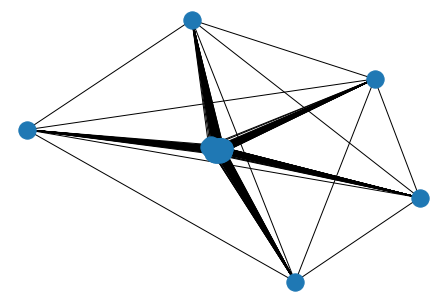

In [14]:
def plot_multifactor_cluster(data, cat_prefix, cluster_name, kind='relplot'):
    '''
        Pivots dummy columns into a single multi-valued categorical column.
        Inverse of listcolumn_pivot_wider ... (defined in ETL/Complaints ETL)
    Inputs:
        data - pandas data frame
        cat_prefix - common prefix to identify dummy columns
        cluster_name - name of cluster label column
        kind - Options: {relplot, graph}
    '''
    # First find all categorical values -- in order!
    dummyvals = []
    for column in data.columns:
        if column.startswith(cat_prefix):
            dummyval = column[len(cat_prefix):]
            dummyvals.append(dummyval)
    
    # Reconstruct single multi-factor column from dummy column so we can use it as axis labels
    catcolumns = data.columns.str.startswith(cat_prefix)
    dummyvals = np.array(dummyvals)
    multiseries = data.loc[:, catcolumns].T.apply(lambda row: dummyvals[row.to_numpy(bool)])
    multiseries = multiseries.apply(lambda x: '|'.join(x))
    
    # Construct adjacency matrix
    dummies = data.loc[:, catcolumns]
    adjacency = dummies.dot(dummies.T)
    
    # Sample adjacency and cluster matrixes because its too many things to plot
    n = len(adjacency)
    p = min(1, 100.0/n)
    sample_mask = np.random.choice([True,False], size=n, p=[p, 1-p])
    adjacency = adjacency.loc[sample_mask, sample_mask]
    
    # This sets the axis labels. We sample and truncate because these strings can get long and crowded
#     label_mask = np.random.choice([False,True], size=len(multiseries), p=[.05,.95])
#     label_sample = multiseries.mask(label_mask, other='')
    label_sample = multiseries.loc[sample_mask]
    label_trunc = label_sample.mask(label_sample.str.len() > 30, other=label_sample.str.slice(0,30)+'...')
#     adjacency.columns = label_trunc

    # Reshape cluster labels into matrix so we can join on adjacency matrix
    cluster_mat = pd.DataFrame(np.diag(data[cluster_name]))

    # Reshape to long form
    adjacency_long = adjacency.stack().reset_index(name='adjacency')
    cluster_long = cluster_mat.stack().reset_index(name=cluster_name)
    plt_df = adjacency_long.merge(cluster_long, left_index=True, right_index=True)
    
    # Plotting
    if kind=='relplot':
        # Attribution: relplot snippet from seaborn docs
        sns.set_theme(style="whitegrid")
        g = sns.relplot(data=plt_df, x='level_0_x', y='level_1_x', \
                    hue=cluster_name, size='adjacency', \
                    palette="vlag", hue_norm=(-1, 1), edgecolor=".7", \
                    height=10, sizes=(50, 250), size_norm=(-.2, .8))
        g.set(title=f"Clustering of {cat_prefix}", aspect='equal', xlabel='', ylabel='')
        g.despine(left=True, bottom=True)
        g.ax.set_yticks(np.linspace(g.ax.get_ylim()[0],g.ax.get_ylim()[1],len(adjacency)))
        g.ax.set_yticklabels(label_trunc)
        g.ax.set_xticks(g.ax.get_yticks())
        g.set_xticklabels(g.ax.get_yticklabels(),rotation=90)
        sns.set_theme()
    elif kind == 'graph':
        G = nx.Graph()
        node_df = pd.concat([multiseries.rename('label'), data[cluster_name].rename('cluster')], axis=1)
        node_tuples = [(row.Index,{"color": row.cluster, "label":row.label}) for row in node_df.itertuples()]
        G.add_nodes_from(node_tuples)
        adjacency_tuples = [(row.level_0, row.level_1, {"weight":row.adjacency}) \
                            for row in adjacency_long.itertuples()]
        G.add_edges_from(adjacency_tuples)
        G.remove_nodes_from(list(nx.isolates(G)))
        nx.draw(G) #, node_color=index into matplotlib colormap
        
test = pd.DataFrame({'B':[1,2,3,4,5], 'A_Foo':[0,1,1,1,1],'A_Bar':[1,1,0,1,1],'A_Baz':[1,1,0,0,0]})
# plot_multifactor_cluster(test, 'A_', 'B', kind='graph')
plot_multifactor_cluster(clustered, 'COMPLAINT_FINDING_', 'KMeans', kind='graph')
